In [1]:
using DrWatson
@quickactivate "Research"

In [109]:
using DataFrames, Plots
pgfplotsx()
theme(:bright)

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1278


In [183]:
function load_efficiency(TS, epsilon, L)
    local efficiency
    try
        fname = savename(@ntuple(TS, epsilon, L), "bson"; connector="-")
        fpath = projectdir("results", "gmm", fname)
        @unpack efficiency = load(fpath)
    catch
        efficiency = missing
    end
    return efficiency
end

@unpack TS_list, epsilon_inc_list, L_inc_list = load(scriptsdir("gmm-sweep.bson"))

results_epsilon_inc, results_inc_L = Dict(), Dict()
for TS in TS_list
    # Collect results from increasing step size
    efficiency_list = []
    for (epsilon, L) in epsilon_inc_list
        push!(efficiency_list, load_efficiency(TS, epsilon, L))
    end
    results_epsilon_inc[TS] = efficiency_list
    # Collect results from increasing step number
    efficiency_list = []
    for (epsilon, L) in L_inc_list
        push!(efficiency_list, load_efficiency(TS, epsilon, L))
    end
    results_inc_L[TS] = efficiency_list
end

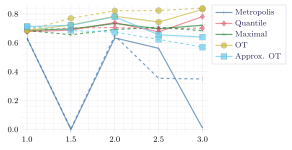

In [186]:
p = plot(size=(350, 250))

length_list = prod.(epsilon_inc_list)
@assert all(length_list .== prod.(L_inc_list))
label_list = ["Metropolis", "Quantile", "Maximal", "OT", "Approx. OT"]
marker_list = [:vline, :diamond, :star, :circle, :rect]
color_list = [1, 2, 3, 4, 5]
kwargs_shared = (markersize = 4, markeralpha = 0.7, alpha = 0.7)
for (TS, label, marker, color) in zip(TS_list, label_list, marker_list, color_list)
    if any(ismissing.(results_epsilon_inc[TS]))
        continue
    else
        plot!(
            p, length_list, results_epsilon_inc[TS]; 
            label=label, style=:solid, marker=marker, color=color, kwargs_shared...
        )
    end
    if any(ismissing.(results_inc_L[TS]))
        continue
    else
        plot!(
            p, length_list, results_inc_L[TS]; 
            label=nothing, style=:dash, marker=marker, color=color, kwargs_shared...
        )
    end
end

savefig(p, projectdir("plots", "gmm.png"))
savefig(p, projectdir("plots", "gmm.pdf"))
savefig(p, projectdir("plots", "gmm.tex"))

p